异常检测task:
1. 可视化数据分布情况，及其对应高斯分布的概率密度函数
2. 建立模型，实现异常数据点预测
3. 可视化异常检测处理结果
4. 修改概率分布阈值contamination

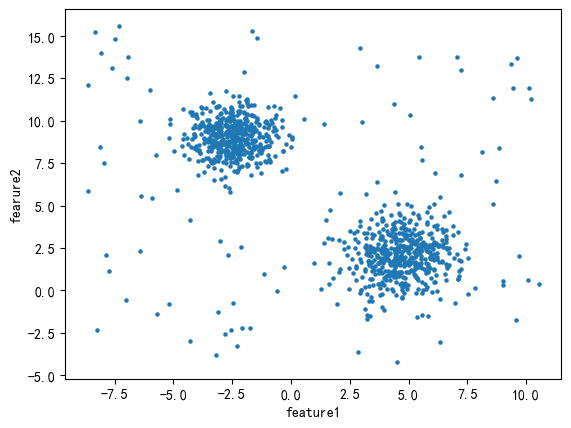

In [31]:
import pandas as pd
import numpy as np
from matplotlib import pyplot as plt
%matplotlib inline
data = pd.read_csv('anomaly_data_1000_100.csv')
#data.head()

plt.rcParams["font.family"] = ["SimHei"]
plt.rcParams['axes.unicode_minus'] = False

fig1 = plt.figure()
plt.scatter(data.loc[:,'feature1'],data.loc[:,'feature2'],s=5)
plt.xlabel('feature1')
plt.ylabel('fearure2')
plt.show()

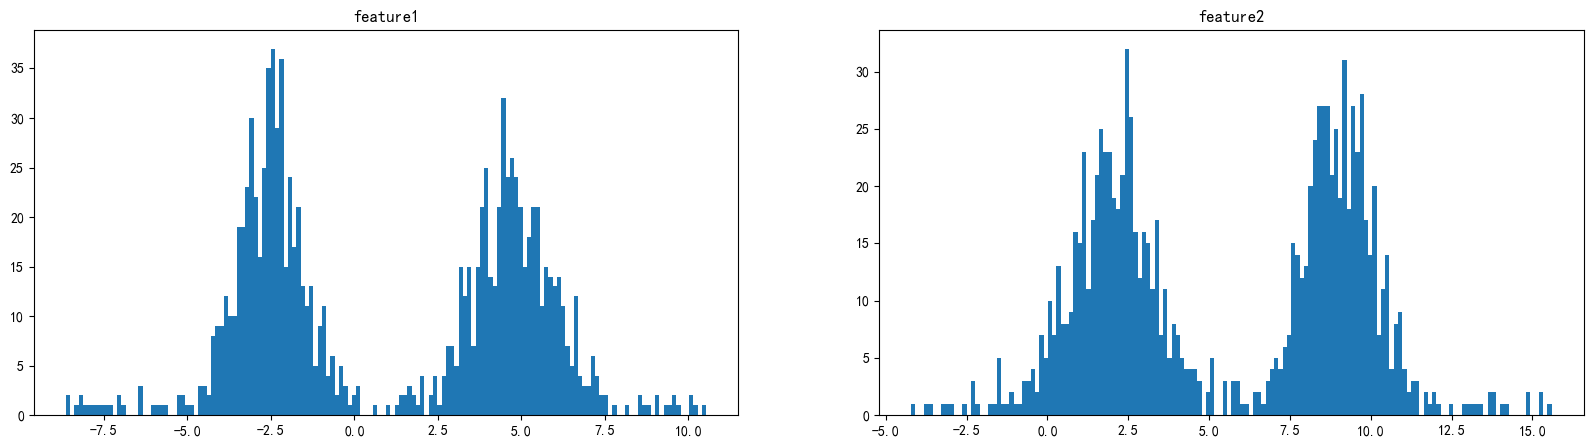

In [32]:
#define x1 and x2
x1 = data.loc[:,'feature1']
x2 = data.loc[:,'feature2']

fig2 = plt.figure(figsize=(20,5))
plt.subplot(121)
plt.hist(x1,bins=150)
plt.title('feature1')
plt.subplot(122)
plt.hist(x2,bins=150)
plt.title('feature2')
plt.show()

特征 feature1 的估计参数：
高斯1：μ=0.14, σ=2.17, 权重=0.72
高斯2：μ=7.51, σ=2.46, 权重=0.28


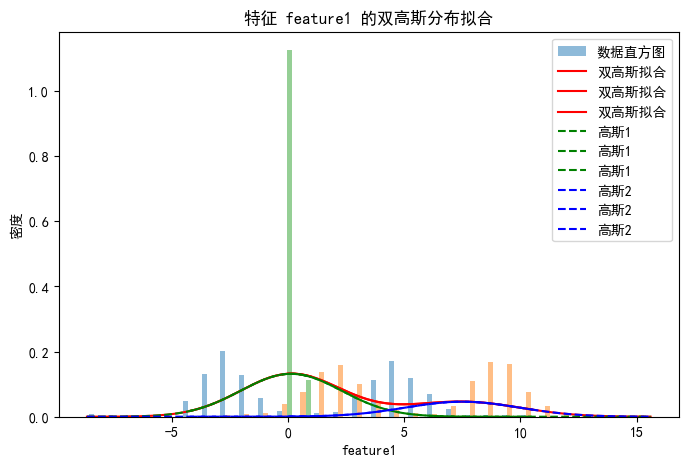

特征 feature2 的估计参数：
高斯1：μ=0.14, σ=2.17, 权重=0.72
高斯2：μ=7.51, σ=2.46, 权重=0.28


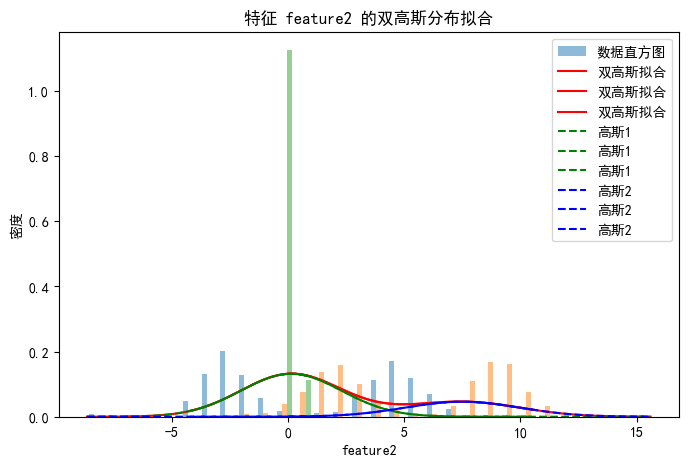

In [33]:
from scipy import stats
from scipy.optimize import minimize


def bimodal_gaussian(x, params):
    mu1, sigma1, w1, mu2, sigma2 = params
    w2 = 1 - w1
    return w1 * stats.norm.pdf(x, mu1, sigma1) + w2 * stats.norm.pdf(x, mu2, sigma2)


# 定义负对数似然函数（用于最小化）
def negative_log_likelihood(params, data):
    return -np.sum(np.log(bimodal_gaussian(data, params) + 1e-10))  # 加小值避免log(0)


# 遍历feature1和feature2
for feature in ['feature1', 'feature2']:
    data_0 = data[feature].values

    # 初始参数估计（可根据直方图大致估计）
    initial_params = [np.min(data), 1, 0.5, np.max(data), 1]  # [mu1, sigma1, w1, mu2, sigma2]

    # 优化求解（最小化负对数似然）
    result = minimize(
        negative_log_likelihood,
        initial_params,
        args=(data,),
        bounds=[(None, None), (0.1, None), (0.01, 0.99), (None, None), (0.1, None)]  # 约束sigma>0, 0<w1<1
    )

    # 估计得到的参数
    mu1, sigma1, w1, mu2, sigma2 = result.x
    w2 = 1 - w1

    print(f"特征 {feature} 的估计参数：")
    print(f"高斯1：μ={mu1:.2f}, σ={sigma1:.2f}, 权重={w1:.2f}")
    print(f"高斯2：μ={mu2:.2f}, σ={sigma2:.2f}, 权重={w2:.2f}")

    # 可视化拟合结果
    x = np.linspace(data.min(), data.max(), 1000)
    plt.figure(figsize=(8, 5))
    plt.hist(data, bins=30, density=True, alpha=0.5, label="数据直方图")
    plt.plot(x, bimodal_gaussian(x, result.x), 'r-', label="双高斯拟合")
    plt.plot(x, w1 * stats.norm.pdf(x, mu1, sigma1), 'g--', label="高斯1")
    plt.plot(x, w2 * stats.norm.pdf(x, mu2, sigma2), 'b--', label="高斯2")
    plt.title(f'特征 {feature} 的双高斯分布拟合')
    plt.xlabel(feature)
    plt.ylabel('密度')
    plt.legend()
    plt.show()

In [34]:
from sklearn.covariance import EllipticEnvelope
ad_model = EllipticEnvelope()
ad_model.fit(data)
y_predict = ad_model.predict(data)

,store_precision,True
,assume_centered,False
,support_fraction,None
,contamination,0.1
,random_state,None


SUMMARY：
1. 通过计算数据各维度对应的高斯分布概率密度函数，可用于寻找到数据中的异常点
2. 通过修改概率密度阈值可调整异常点检测的灵敏度
3. [参考链接](heeps://scikit-learn.org/stable/modules/generated/sklearn.covariance.EllipticEnvelope.html?highlight=ellipticenvelope)

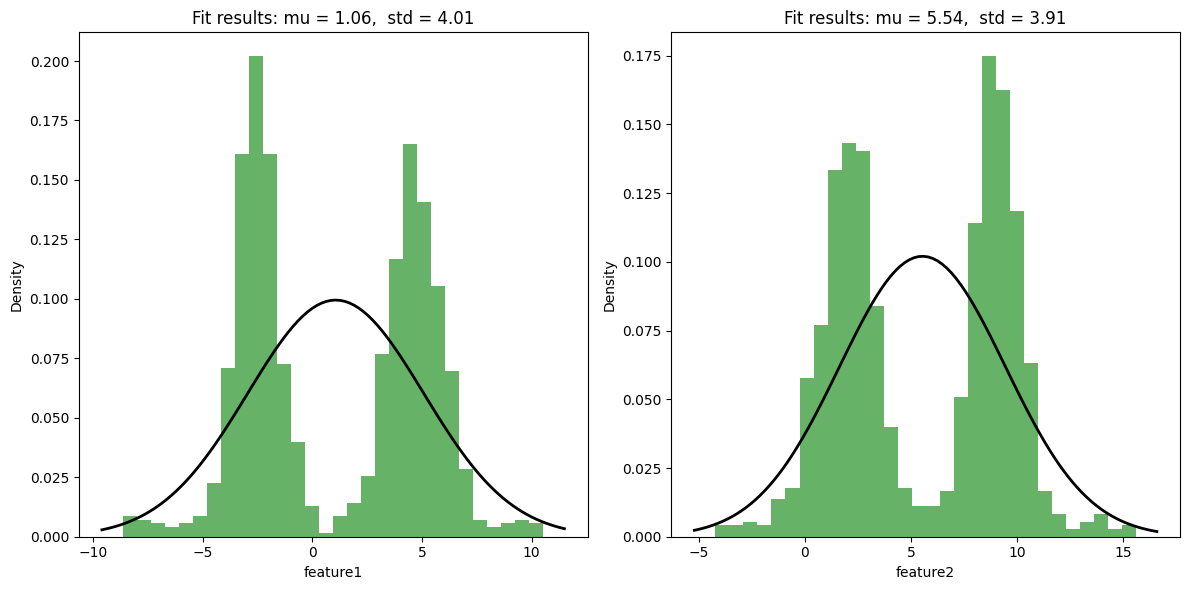

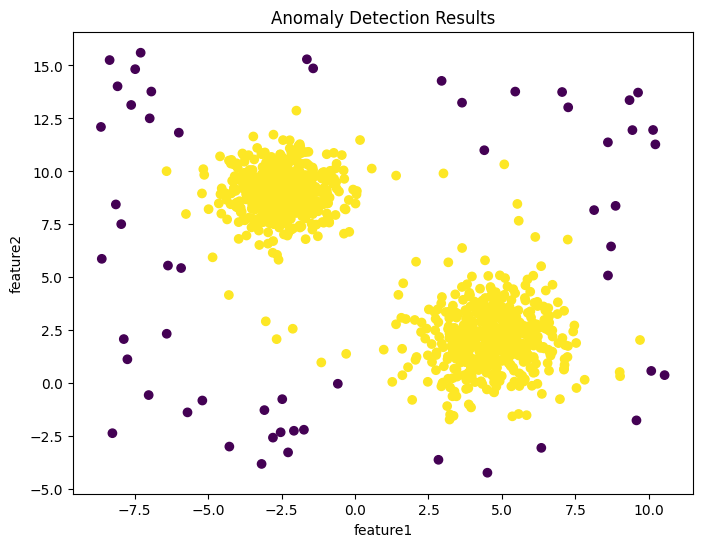

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import norm
import matplotlib.pyplot as plt
from sklearn.ensemble import IsolationForest

# 加载数据
df = pd.read_csv('anomaly_data_1000_100.csv')

# 选择特征列
features = ['feature1', 'feature2']

# 可视化数据分布和高斯分布概率密度函数
plt.figure(figsize=(12, 6))
for i, feature in enumerate(features):
    plt.subplot(1, 2, i + 1)
    data = df[feature]
    mu, std = norm.fit(data)
    plt.hist(data, bins=30, density=True, alpha=0.6, color='g')
    xmin, xmax = plt.xlim()
    x = np.linspace(xmin, xmax, 100)
    p = norm.pdf(x, mu, std)
    plt.plot(x, p, 'k', linewidth=2)
    title = "Fit results: mu = %.2f,  std = %.2f" % (mu, std)
    plt.title(title)
    plt.xlabel(feature)
    plt.ylabel('Density')

plt.tight_layout()
plt.show()

# 建立孤立森林模型，修改contamination参数
contamination = 0.05  # 可以修改这个值
clf = IsolationForest(contamination=contamination)
clf.fit(df[features])

# 预测异常点
df['is_outlier'] = clf.predict(df[features])

# 可视化异常检测结果
plt.figure(figsize=(8, 6))
plt.scatter(df['feature1'], df['feature2'], c=df['is_outlier'])
plt.xlabel('feature1')
plt.ylabel('feature2')
plt.title('Anomaly Detection Results')
plt.show()